# Reasearch on OLS, 2OLS #


### 1. Import library

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

In [64]:
CPI_D = pd.read_csv('CPI.csv',encoding='utf-8-sig')
HOUSE_INDEX = pd.read_csv('houseindex.csv',encoding='utf-8-sig')
MORTAGECREDIT = pd.read_csv('mortgagecredit.csv',encoding='utf-8-sig')
MORTAGERATE = pd.read_csv('mortgagerate.csv',encoding='utf-8-sig')
NEW_HOME_SALES = pd.read_csv('newhomes.csv',encoding='utf-8-sig')
NEW_CONDOS = pd.read_csv('newcondos.csv',encoding='utf-8-sig')
UNEMPLOYED = pd.read_csv('unemplyed.csv',encoding='utf-8-sig')


In [ ]:
df = pd.merge(CPI_D, HOUSE_INDEX, on='REF_DATE', how='outer')  
df = pd.merge(df, MORTAGECREDIT, on='REF_DATE', how='outer') 
df = pd.merge(df, MORTAGERATE, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_HOME_SALES, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_CONDOS, on='REF_DATE', how='outer') 
df = pd.merge(df, UNEMPLOYED, on='REF_DATE', how='outer')
df['REF_DATE'] = pd.to_datetime(df['REF_DATE']) 
df['TimeTrend'] = np.arange(1, len(df) + 1)
df = df.dropna()  
df['TimeTrend'] = df['TimeTrend'] - 444
df['CREDIT'] = df['CREDIT'] / 10000 #Now the unit is 10 billion CAD
print(df)  
df.info()  

      REF_DATE    CPI  HINDEX    CREDIT  MRATE    HNUM    CNUM  URATE  \
444 1988-11-01   72.3    55.0   19.2308  11.78  8318.0  3844.0   10.2   
445 1988-12-01   72.3    55.8   19.4579  12.13  7249.0  2670.0    9.8   
446 1989-01-01   72.7    56.3   19.6837  12.24  5990.0  4667.0   11.3   
447 1989-02-01   73.2    57.7   19.9273  12.23  5024.0  2137.0   11.1   
448 1989-03-01   73.6    58.6   20.1617  12.41  6423.0  3310.0   11.0   
..         ...    ...     ...       ...    ...     ...     ...    ...   
818 2020-01-01  136.8   103.4  164.0113   4.08  4000.0  2806.0    8.8   
819 2020-02-01  137.4   103.8  164.4740   4.08  4302.0  4021.0    8.9   
820 2020-03-01  136.6   104.1  165.2870   3.90  4655.0  4196.0   15.1   
821 2020-04-01  135.7   104.1  166.2719   3.95  3603.0  5444.0   22.6   
826 2020-09-01  136.9   106.5  170.5636   3.51  6395.0  5250.0   14.1   

     TimeTrend  
444          1  
445          2  
446          3  
447          4  
448          5  
..         ...  
818 

In [66]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 444 to 826
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   REF_DATE   255 non-null    datetime64[ns]
 1   CPI        255 non-null    float64       
 2   HINDEX     255 non-null    float64       
 3   CREDIT     255 non-null    float64       
 4   MRATE      255 non-null    float64       
 5   HNUM       255 non-null    float64       
 6   CNUM       255 non-null    float64       
 7   URATE      255 non-null    float64       
 8   TimeTrend  255 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 19.9 KB


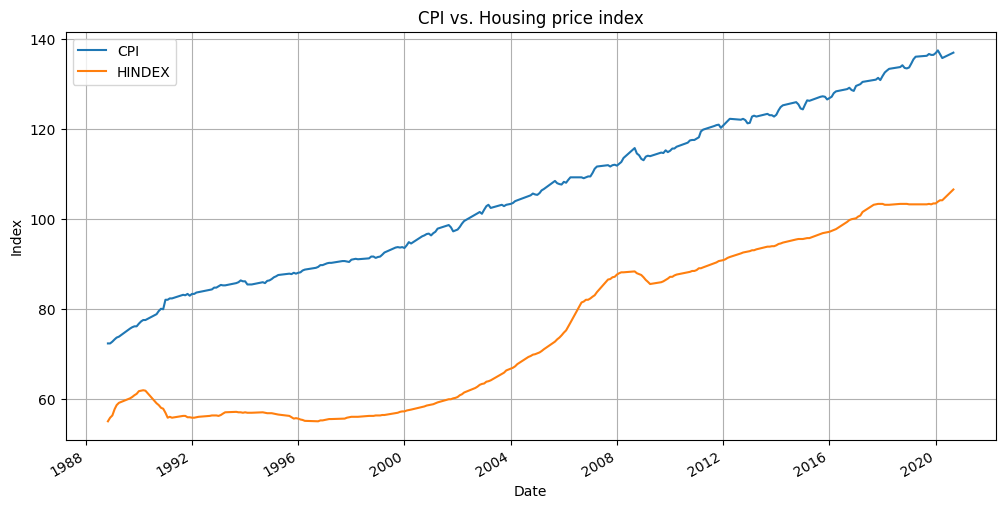

In [81]:
import matplotlib.pyplot as plt

# Plotting the CPI and Housing Price Index
df.plot(x='REF_DATE', y=['CPI', 'HINDEX'], 
       figsize=(12, 6), title='CPI vs. Housing price index')
plt.xlabel('Date')
plt.ylabel('Index')
plt.grid(True)
plt.show()

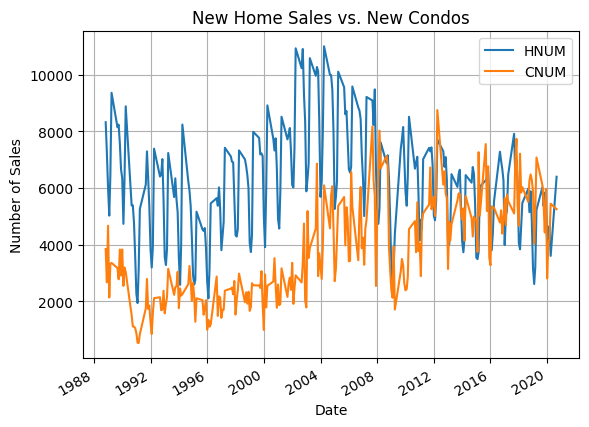

In [82]:
df.plot(x='REF_DATE', y=['HNUM','CNUM'],)
plt.title('New Home Sales vs. New Condos')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.grid(True)
plt.show()


In [89]:
controls = ['URATE', 'HNUM', 'CPI', 'TimeTrend', 'CNUM']
Y = 'HINDEX'
endog = 'CREDIT'
instrument = 'MRATE'
control_vars = '+'.join(controls)
formula = f"{Y} ~ 1 + [{endog} ~ {instrument}] + {control_vars}"
iv_model = IV2SLS.from_formula(formula, data=df).fit(cov_type='robust')
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 HINDEX   R-squared:                      0.9576
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9565
No. Observations:                 255   F-statistic:                    7545.2
Date:                Mon, May 05 2025   P-value (F-stat)                0.0000
Time:                        11:45:33   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.1349     12.821     0.0885     0.9295     -23.993      26.263
URATE         -0.4768     0.1580    -3.0181     0.00

In [90]:
print(iv_model.first_stage)


    First Stage Estimation Results    
                                CREDIT
--------------------------------------
R-squared                       0.9727
Partial R-squared               0.3482
Shea's R-squared                0.3482
Partial F-statistic             110.91
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                      -198.94
                             (-6.6472)
URATE                           1.2488
                              (3.4831)
HNUM                           -0.0017
                             (-5.9164)
CPI                             1.6349
                              (3.4902)
TimeTrend                       0.2628
                              (3.1357)
CNUM                            0.0008
                              (1.4898)
MRATE                           6.5316
                              (10.531)
--------------------------------------

T-stats reported in pare

### Linear regression prediction

In [106]:
from sklearn import (           
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [174]:
df2 = df.copy()
X = df2[['CPI', 'CREDIT','MRATE','HNUM','CNUM','URATE','TimeTrend']].values
y = df2['HINDEX'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,random_state=42)


In [175]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
baseline_mse = np.mean((y_test - np.mean(y_train))**2)
print("Baseline MSE:", baseline_mse)

Coefficients: [ 1.01109596e+00  2.13420226e-01  1.52170664e+00 -7.31127585e-05
  8.74180623e-04 -1.76379049e-01 -7.45021653e-02]
Intercept: -44.214099403753224
R-squared: 0.97244554791382
MSE: 8.66929553892069
Baseline MSE: 316.48691815602643


In [186]:
cv_model = LinearRegression()
cv_scores = cross_val_score(cv_model, X, y, cv=10, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  
print("Cross-validated MSE scores:", cv_mse_scores)
print("Mean CV MSE:", -np.mean(cv_scores))


Cross-validated MSE scores: [142.17987262   3.88483711   6.20210809  37.39519362  17.13205177
  29.97028285  46.54120725   5.11983681   2.86527796  91.3173269 ]
Mean CV MSE: 38.260799498974954


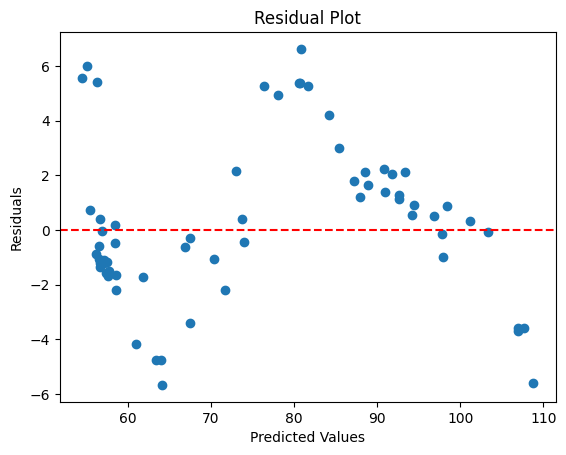

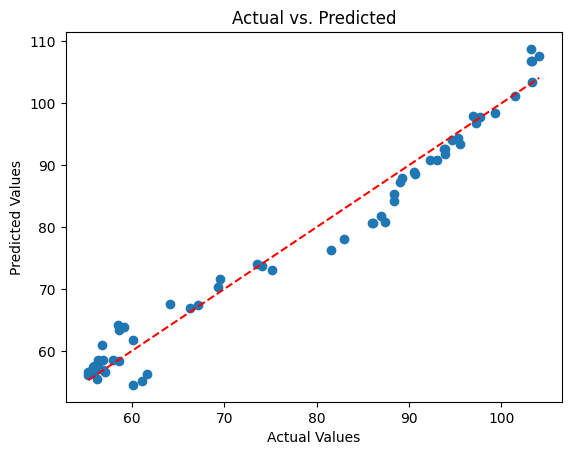

In [176]:
import matplotlib.pyplot as plt

# 1. Residual Plot
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

In [129]:
df

,REF_DATE,CPI,HINDEX,CREDIT,MRATE,HNUM,CNUM,URATE,TimeTrend
444,1988-11-01,72.3,55.0,19.2308,11.78,8318.0,3844.0,10.2,1
445,1988-12-01,72.3,55.8,19.4579,12.13,7249.0,2670.0,9.8,2
446,1989-01-01,72.7,56.3,19.6837,12.24,5990.0,4667.0,11.3,3
447,1989-02-01,73.2,57.7,19.9273,12.23,5024.0,2137.0,11.1,4
448,1989-03-01,73.6,58.6,20.1617,12.41,6423.0,3310.0,11.0,5
...,...,...,...,...,...,...,...,...,...
818,2020-01-01,136.8,103.4,164.0113,4.08,4000.0,2806.0,8.8,375
819,2020-02-01,137.4,103.8,164.4740,4.08,4302.0,4021.0,8.9,376
820,2020-03-01,136.6,104.1,165.2870,3.90,4655.0,4196.0,15.1,377
821,2020-04-01,135.7,104.1,166.2719,3.95,3603.0,5444.0,22.6,378


In [159]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train a neural network model
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=10000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = mlp.predict(X_test_scaled)

# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_pred)
print("Model MSE:", model_mse)

# baseline MSE
baseline_pred = np.full_like(y_test, np.mean(y_train), dtype=float)
baseline_mse = mean_squared_error(y_test, baseline_pred)
print("Baseline MSE:", baseline_mse)

# compare model MSE with baseline MSE
improvement = baseline_mse - model_mse
print("Improvement over baseline:", improvement)

Model MSE: 1.4476089590342163
Baseline MSE: 316.48691815602643
Improvement over baseline: 315.03930919699224


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(32, 16),
        max_iter=10000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=1000,
        random_state=42
    ))
])

# cross-validation, 10-fold, negative MSE
cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# output
print("Cross-Validation MSE:", -cv_scores)
print("Mean CV MSE:", -np.mean(cv_scores))  # 取负得到正 MSE
print("Standard Deviation of CV MSE:", np.std(cv_scores))

Cross-Validation MSE: [  8.17913462   3.35773676   0.26161634   1.54597245   3.61322296
  13.09195563   3.89623995   0.46789698   1.02959611 122.93822652]
Mean CV MSE: 15.838159832838096
Standard Deviation of CV MSE: 35.89830072317522
